In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import torch.nn as nn
import cv2 as cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.utils as vutils
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 

%matplotlib inline
# path to the image directory
dir_data  = "Type_II_trainingset"
 
# setting image shape to 32x32
img_shape = (128, 128, 3)
 
# listing out all file names
nm_imgs   = np.sort(os.listdir(dir_data))


In [2]:
X_train = []
for file in nm_imgs:
    img = Image.open(dir_data+'/'+file)
    img = img.convert('RGB')
    img = img.resize((128,128))
    img = np.asarray(img)/255
    X_train.append(img)
 
X_train = np.array(X_train)
X_train.shape

(162, 128, 128, 3)

In [3]:
from numpy import asarray
from numpy import savez_compressed
 
# save to npy file
savez_compressed('SRB_images.npz', X_train)

In [4]:
# load dict of arrays
dict_data = np.load('SRB_images.npz')
 
# extract the first array
data = dict_data['arr_0']
 
# print the array
print(data)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.36078431 0.36078431 0.36078431]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.29411765 0.29411765 0.29411765]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.12156863 0.12156863 0.12156863]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.10980392 0.10980392 0.10980392]
   [0.05098039 0.05098039 0.05098039]
   [0.02352941 0.02352941 0.02352941]]

  [[0.         0.         0.        ]
   [0. 

In [5]:
# plot images in a nxn grid


def plot_images(imgs,n):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """    
    
    fig = plt.figure(figsize = (5, 5))
    #columns = rows = grid_size
    #plt.title("Training Images")
    
    
    plt.axis("off")
    #fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[0])
    plt.savefig('Generated3/Image_{:04d}.png'.format(n),transparent=True,bbox_inches='tight',pad_inches=0.05)
    plt.show()
    plt.close()

In [6]:
# load the numpy vector containing image representations
imgs = np.load('SRB_images.npz')

# to check all the files contained in it
imgs.files

# this is where all our images are saved
imgs['arr_0'].shape


(162, 128, 128, 3)

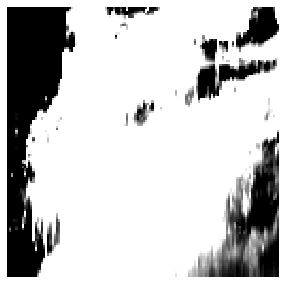

In [7]:
# 128X128 training images
plot_images(imgs['arr_0'], 3)

In [8]:
# Always good to check if gpu support available or not

dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(dev)


In [9]:
# To check the device name
print ('Current cuda device name ', torch.cuda.get_device_name())

Current cuda device name  NVIDIA GeForce RTX 2080 SUPER


In [10]:

class SRBDataset(Dataset):
    """SRB dataset."""

    def __init__(self, npz_imgs):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.imgs = npz_imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.imgs[idx]

        return image

In [11]:
imgs['arr_0'][0].dtype # it will output float 128 i.e. double

# must convert it to FLOAT 128 (which is same as model weights)
np.longdouble(imgs['arr_0']).dtype

dtype('float128')

In [12]:
# Preparing dataloader for training

transpose_imgs = np.transpose( 
    np.float32(imgs['arr_0']), # imp step to convert double -> float (by default numpy input uses double as data type)
    (0, 3,1,2) # tuple to describe how to rearrange the dimensions
    ) 

dset = SRBDataset(transpose_imgs) # passing the npz variable to the constructor class
batch_size = 32
shuffle = True

dataloader = DataLoader(dataset = dset, batch_size = batch_size, shuffle = shuffle)


In [13]:
# Defining the Generator class

class Generator(Module):
    def __init__(self):

        # calling constructor of parent class
        super().__init__()

        self.gen = Sequential(
          ConvTranspose2d(in_channels = 100, out_channels = 1024 , kernel_size = 4, stride = 1, padding = 0, bias = False),
          # the output from the above will be b_size ,512, 4,4
          BatchNorm2d(num_features = 1024), # From an input of size (b_size, C, H, W), pick num_features = C
          ReLU(inplace = True),

          ConvTranspose2d(in_channels = 1024, out_channels = 512 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,256, 8,8
          BatchNorm2d(num_features = 512),
          ReLU(inplace = True),

          ConvTranspose2d(in_channels = 512, out_channels = 256 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,128, 16,16
          BatchNorm2d(num_features = 256),
          ReLU(inplace = True),

          ConvTranspose2d(in_channels = 256, out_channels = 128 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          BatchNorm2d(num_features = 128),
          ReLU(inplace = True),
            
          ConvTranspose2d(in_channels = 128, out_channels = 64 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          BatchNorm2d(num_features = 64),
          ReLU(inplace = True),
          
          # the output from the above will be b_size ,3, 32,32
          ConvTranspose2d(in_channels = 64, out_channels = 3 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          Tanh()
        
        )

    def forward(self, input):
        return self.gen(input)




In [14]:
netG = Generator().to(device)

print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNo

In [15]:
# As an example, to show the shape of the output from the generator -  must be an image
t = torch.randn(2, 100, 1, 1)
netG(t.to(device)).shape

torch.Size([2, 3, 128, 128])

In [16]:
def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [17]:
# Let's initialize the weights randomly (for a single layer)
netG.apply(init_weights)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNo

In [18]:
# Defining the Discriminator class

class Discriminator(Module):
    def __init__(self):

        super().__init__()
        self.dis = Sequential(

            # input is (3, 32, 32)
            Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32, 16, 16
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*2, 8, 8
            BatchNorm2d(64 * 2),
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*4, 4, 4
            BatchNorm2d(64 * 4),
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 2, 2
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            BatchNorm2d(64 * 8),
            LeakyReLU(0.2, inplace=True),
            
            Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 2, 2
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            BatchNorm2d(64 * 16),
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 1024, out_channels = 1, kernel_size = 4, stride = 1, padding = 0, bias=False),
            # ouput from above layer is b_size, 1, 1, 1
            Sigmoid()
        )
    
    def forward(self, input):
        return self.dis(input)

In [19]:
# As an example, to show the shape of the output from the generator -  must be an integer
t = torch.randn(2, 3, 128, 128)

netD = Discriminator().to(device)
netD(t.to(device)).shape

torch.Size([2, 1, 1, 1])

In [20]:
# initializing the weights
netD.apply(init_weights)

print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05,

In [21]:
# Setting up otimizers for both Generator and Discriminator

opt_D = optim.Adam(netD.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_G = optim.Adam(netG.parameters(), lr = 0.0002, betas= (0.5, 0.999))


In [22]:
# Setting up the loss function - BCELoss (to check how far the predicted value is from real value)

loss = BCELoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


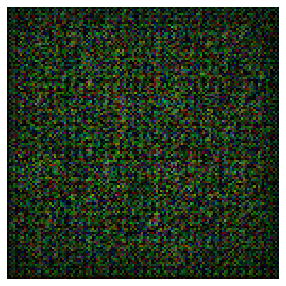

********************
 Epoch 0 and iteration 5 discriminator loss= 3.731309 generator loss= 25.286926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


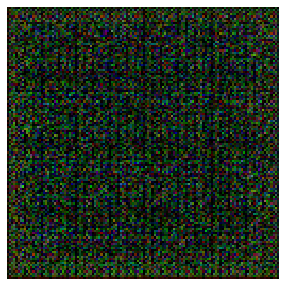

********************
 Epoch 1 and iteration 5 discriminator loss= 2.671225 generator loss= 27.935480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


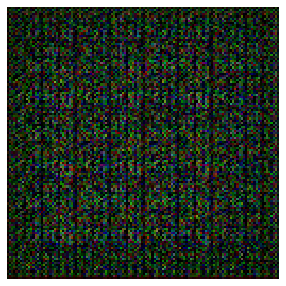

********************
 Epoch 2 and iteration 5 discriminator loss= 0.881263 generator loss= 19.308182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


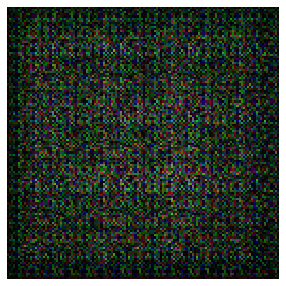

********************
 Epoch 3 and iteration 5 discriminator loss= 0.033465 generator loss= 18.082798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


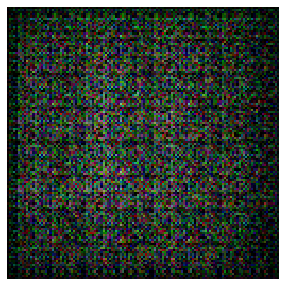

********************
 Epoch 4 and iteration 5 discriminator loss= 0.013460 generator loss= 12.127932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


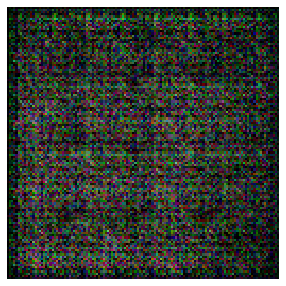

********************
 Epoch 5 and iteration 5 discriminator loss= 0.009520 generator loss= 8.194393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


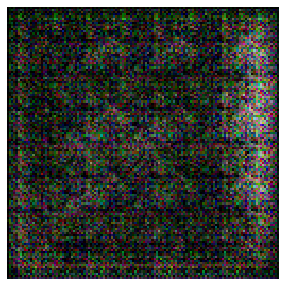

********************
 Epoch 6 and iteration 5 discriminator loss= 0.387453 generator loss= 10.234133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


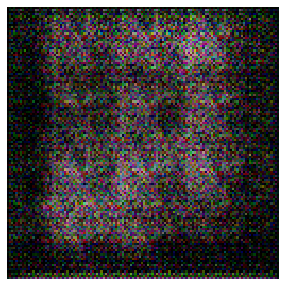

********************
 Epoch 7 and iteration 5 discriminator loss= 0.045361 generator loss= 8.189187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


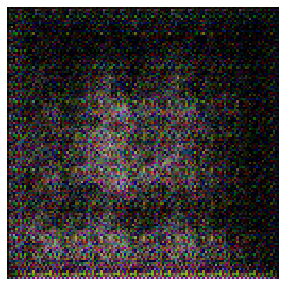

********************
 Epoch 8 and iteration 5 discriminator loss= 1.914102 generator loss= 5.323312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


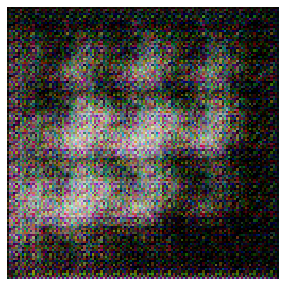

********************
 Epoch 9 and iteration 5 discriminator loss= 0.219472 generator loss= 5.015126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


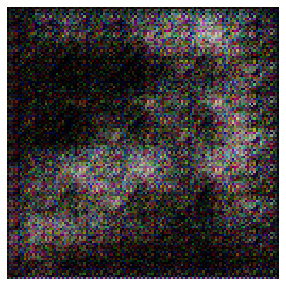

********************
 Epoch 10 and iteration 5 discriminator loss= 0.245729 generator loss= 11.922123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


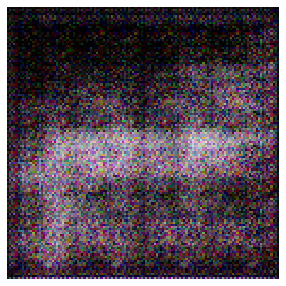

********************
 Epoch 11 and iteration 5 discriminator loss= 0.829079 generator loss= 1.865773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


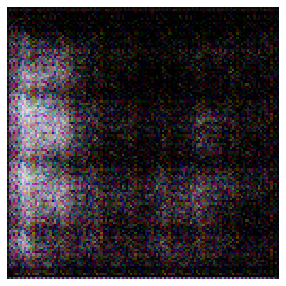

********************
 Epoch 12 and iteration 5 discriminator loss= 0.847225 generator loss= 12.410913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


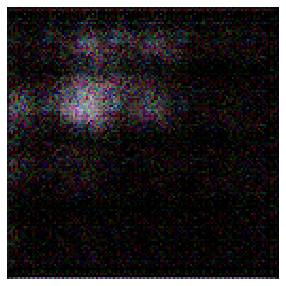

********************
 Epoch 13 and iteration 5 discriminator loss= 0.228434 generator loss= 3.930671


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


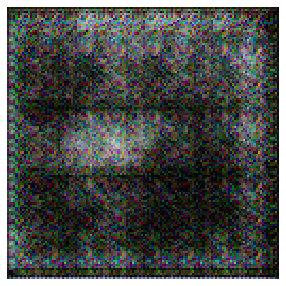

********************
 Epoch 14 and iteration 5 discriminator loss= 1.324187 generator loss= 4.535382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


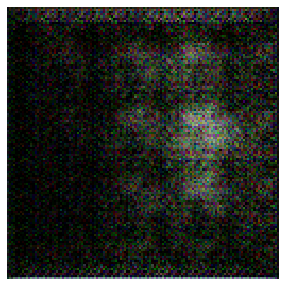

********************
 Epoch 15 and iteration 5 discriminator loss= 2.424462 generator loss= 1.371669


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


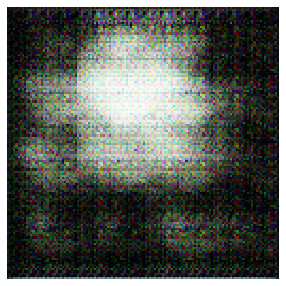

********************
 Epoch 16 and iteration 5 discriminator loss= 0.169306 generator loss= 3.850810


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


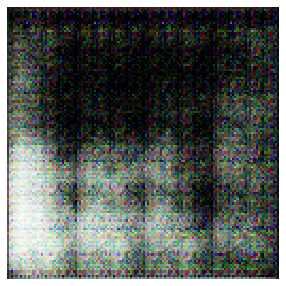

********************
 Epoch 17 and iteration 5 discriminator loss= 1.452643 generator loss= 5.676813


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


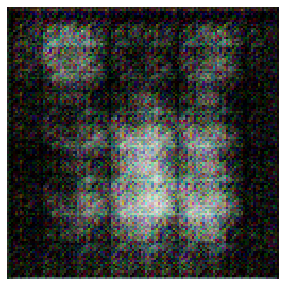

********************
 Epoch 18 and iteration 5 discriminator loss= 0.467347 generator loss= 7.096212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


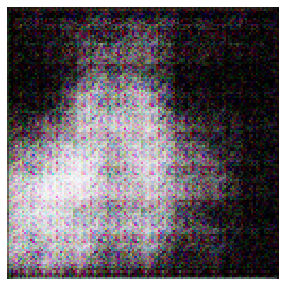

********************
 Epoch 19 and iteration 5 discriminator loss= 0.692736 generator loss= 1.008683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


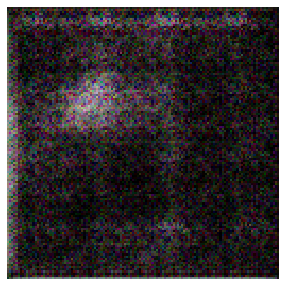

********************
 Epoch 20 and iteration 5 discriminator loss= 0.055537 generator loss= 4.605130


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


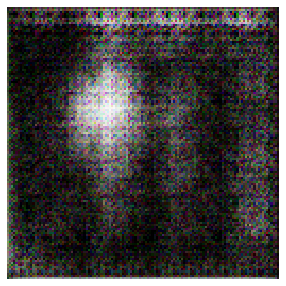

********************
 Epoch 21 and iteration 5 discriminator loss= 0.416337 generator loss= 10.268206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


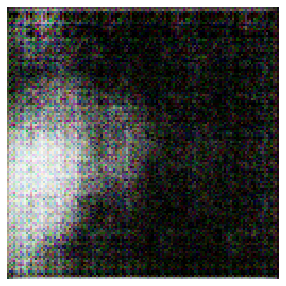

********************
 Epoch 22 and iteration 5 discriminator loss= 2.395300 generator loss= 14.881779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


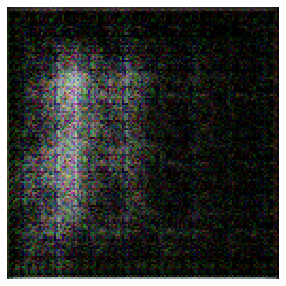

********************
 Epoch 23 and iteration 5 discriminator loss= 0.870782 generator loss= 2.895730


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


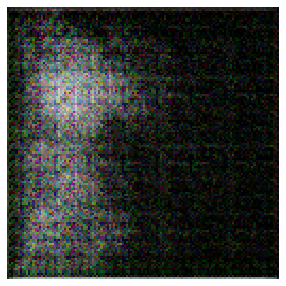

********************
 Epoch 24 and iteration 5 discriminator loss= 0.267403 generator loss= 3.217498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


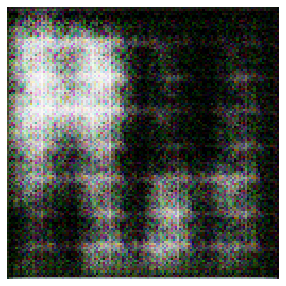

********************
 Epoch 25 and iteration 5 discriminator loss= 0.455726 generator loss= 2.494252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


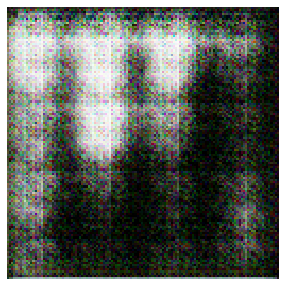

********************
 Epoch 26 and iteration 5 discriminator loss= 0.182066 generator loss= 3.913076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


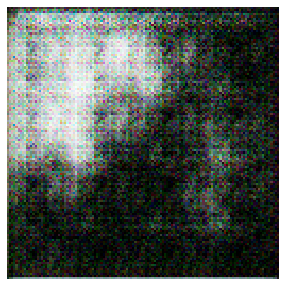

********************
 Epoch 27 and iteration 5 discriminator loss= 0.248278 generator loss= 5.936150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


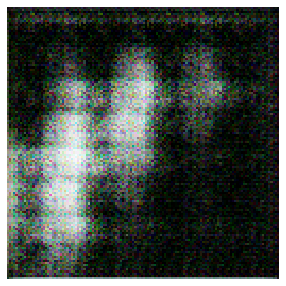

********************
 Epoch 28 and iteration 5 discriminator loss= 1.266837 generator loss= 2.728837


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


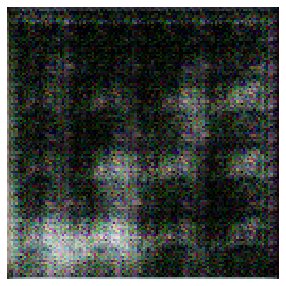

********************
 Epoch 29 and iteration 5 discriminator loss= 0.892730 generator loss= 0.517709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


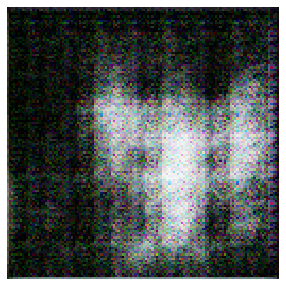

********************
 Epoch 30 and iteration 5 discriminator loss= 0.433972 generator loss= 3.101799


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


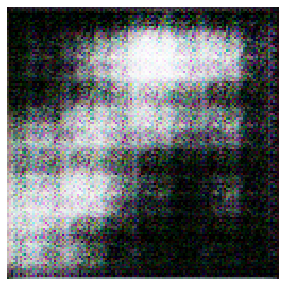

********************
 Epoch 31 and iteration 5 discriminator loss= 0.252594 generator loss= 5.776787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


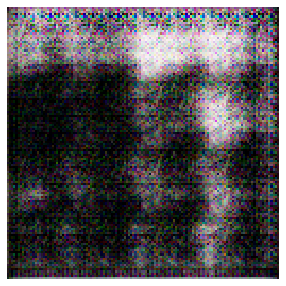

********************
 Epoch 32 and iteration 5 discriminator loss= 2.637445 generator loss= 3.287374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


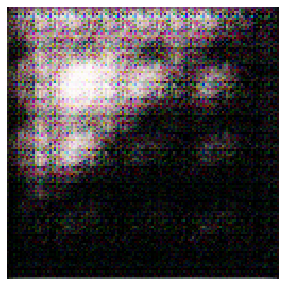

********************
 Epoch 33 and iteration 5 discriminator loss= 0.241973 generator loss= 5.687101


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


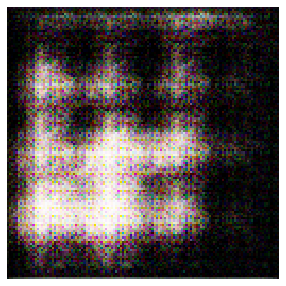

********************
 Epoch 34 and iteration 5 discriminator loss= 0.326352 generator loss= 5.311947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


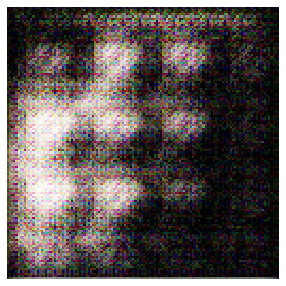

********************
 Epoch 35 and iteration 5 discriminator loss= 0.183395 generator loss= 6.691040


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


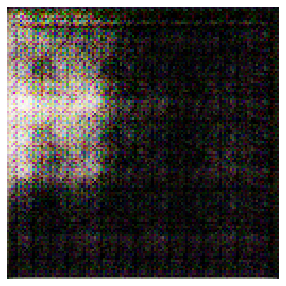

********************
 Epoch 36 and iteration 5 discriminator loss= 0.353998 generator loss= 4.045308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


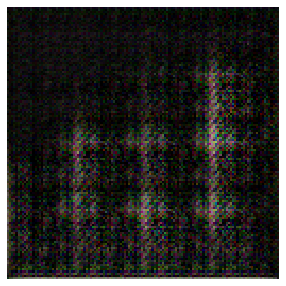

********************
 Epoch 37 and iteration 5 discriminator loss= 0.263294 generator loss= 3.234730


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


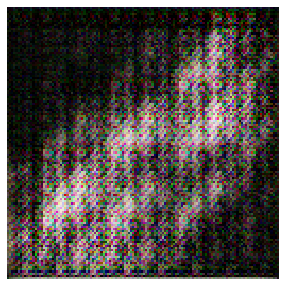

********************
 Epoch 38 and iteration 5 discriminator loss= 0.188544 generator loss= 4.949665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


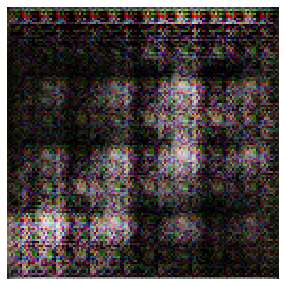

********************
 Epoch 39 and iteration 5 discriminator loss= 0.693449 generator loss= 13.599046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


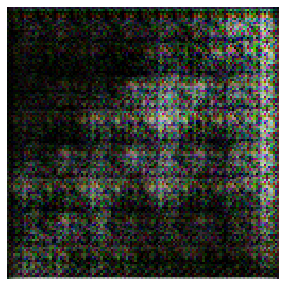

********************
 Epoch 40 and iteration 5 discriminator loss= 0.249817 generator loss= 3.829206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


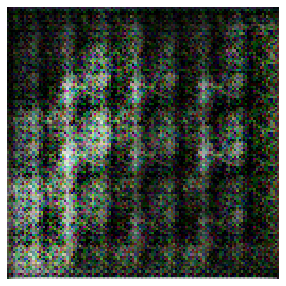

********************
 Epoch 41 and iteration 5 discriminator loss= 0.446677 generator loss= 11.065652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


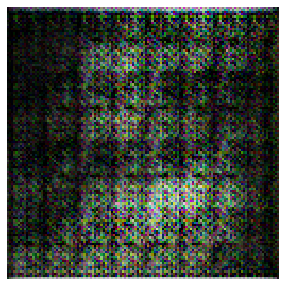

********************
 Epoch 42 and iteration 5 discriminator loss= 0.402344 generator loss= 6.090271


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


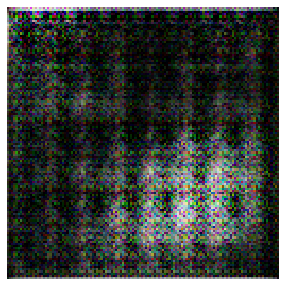

********************
 Epoch 43 and iteration 5 discriminator loss= 0.486547 generator loss= 1.061631


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


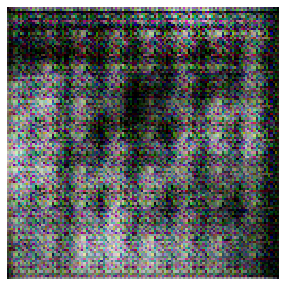

********************
 Epoch 44 and iteration 5 discriminator loss= 1.155592 generator loss= 4.453835


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


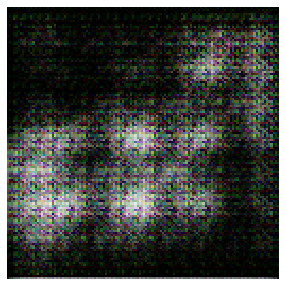

********************
 Epoch 45 and iteration 5 discriminator loss= 0.147460 generator loss= 4.922499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


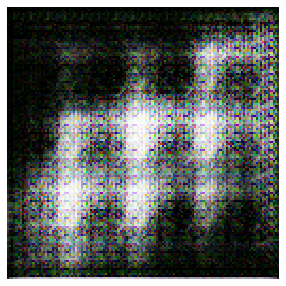

********************
 Epoch 46 and iteration 5 discriminator loss= 0.185201 generator loss= 6.577382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


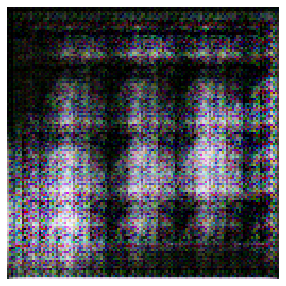

********************
 Epoch 47 and iteration 5 discriminator loss= 0.169121 generator loss= 7.899287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


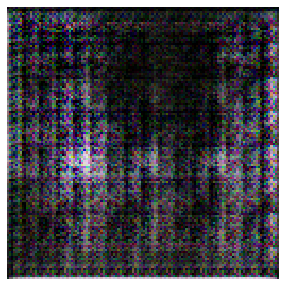

********************
 Epoch 48 and iteration 5 discriminator loss= 2.251896 generator loss= 0.657479


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


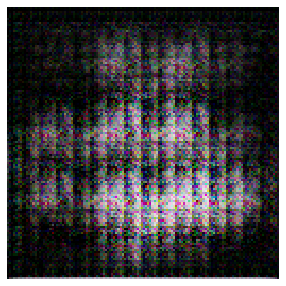

********************
 Epoch 49 and iteration 5 discriminator loss= 0.958248 generator loss= 4.052094


In [23]:
# TRAINING GANS
epochs = 50
L=[]
I=[]
# going over the entire dataset epoch times
for e in range(epochs):
    
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):

        ##########################
        ## Update Discriminator ##
        ##########################

        # Loss on real images
        
        # clear the gradient
        opt_D.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD(b.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()

        # Loss on fake images

        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_img = netG(noise) 
        
        # compute D model output on fake images
        yhat = netD.cuda()(fake_img.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake = loss(yhat, target)
        # calculate gradients
        loss_fake.backward()

        # total error on D
        loss_disc = loss_real + loss_fake
        # Update weights of D
        opt_D.step()

        ##########################
        #### Update Generator ####
        ##########################

        # clear gradient
        opt_G.zero_grad()
        # pass fake image through D
        yhat = netD.cuda()(fake_img).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss(yhat, target)
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()


        ####################################
        #### Plot some Generator images ####
        ####################################

        # during every epoch, print images at every 10th iteration.
        """"
        if i% 100 == 0:
            fake=netG(noise)
            vutils.save_image(fake.data,'%s/fake_examples_epoch_%04d.png' % ("./Generated_grid",e),normalize=True)
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
            img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1))# .detach().cpu() is imp for copying fake_img tensor to host memory first
            plot_images(img_plot,e)
            print("********************")
            print(" Epoch %d and iteration %d discriminator loss= %f generator loss= %f" % (e, i,loss_disc,loss_gen))
            disc=loss_disc.detach().cpu().numpy()
            gen=loss_gen.detach().cpu().numpy()
            L.append(loss_disc.item())
            I.append(loss_gen.item())
        """
    fake=netG(noise)
    vutils.save_image(fake.data,'%s/fake_examples_epoch_%04d.png' % ("./Generated_grid",e),normalize=True)
    # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
    img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1))# .detach().cpu() is imp for copying fake_img tensor to host memory first
    plot_images(img_plot,e)
    print("********************")
    print(" Epoch %d and iteration %d discriminator loss= %f generator loss= %f" % (e, i,loss_disc,loss_gen))
    disc=loss_disc.detach().cpu().numpy()
    gen=loss_gen.detach().cpu().numpy()
    L.append(loss_disc.item())
    I.append(loss_gen.item())

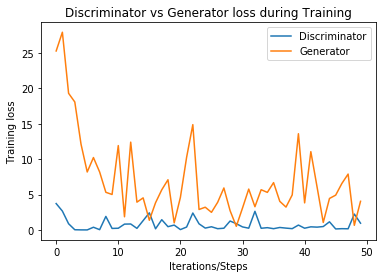

In [24]:
fig, ax = plt.subplots()
ax.plot(L, label='Discriminator')
ax.plot(I, label='Generator')
ax.set_xlabel('Iterations/Steps')
ax.set_ylabel('Training loss')
ax.set_title("Discriminator vs Generator loss during Training")
ax.legend()